In [70]:
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
from math import atan, degrees, radians
import seaborn as sns
import pandas as pd
import numpy as np
import h5py

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

In [86]:
class LSTMBinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, kernel_size=7):
        super(LSTMBinaryClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.conv = nn.Conv1d(in_channels=input_size, out_channels=hidden_size, kernel_size=kernel_size, padding=1)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        
        self.dropout = nn.Dropout(0.3)
        
        self.fc = nn.Linear(hidden_size, output_size)
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Применяем сверточный слой
        x = x.permute(0, 2, 1)  # (batch_size, input_size, seq_len) -> (batch_size, seq_len, input_size)
        x = self.conv(x)        # (batch_size, hidden_size, seq_len)
        x = x.permute(0, 2, 1)  # (batch_size, seq_len, hidden_size)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))

        out = self.dropout(out[:, -1, :])
        out = self.fc(out)    # Берем только последний выход LSTM
        out = self.sigmoid(out)         # Применяем сигмоиду для получения вероятности
        return out

In [72]:
def load_data(metadata_filepath, sample_freq, N_start=0, N_end=10, only_health=False):
    """Загрузка данных из файлов.\n
    Работает только при наличии директории 'records',\n
    в которой пять папок по 5000 файлов записей"""
    
    # Загружаем метаданные и выбираем срезом нужные
    metadata_full = pd.read_csv('metadata.csv')
    metadata = metadata_full.iloc[N_start:N_end]

    # Убираем лишние столбцы, приводим к типу int32
    metadata = metadata.drop(columns=['Date', 'Patient_ID'])
    metadata['Age'].astype(np.int32)
    metadata['N'].astype(np.int32)


    if only_health:
        # Берём только здоровых людей
        health_metadata = metadata.loc[metadata['AHA_Code'] == '1']
        id_metadata = health_metadata['ECG_ID'].values
        labels = health_metadata['AHA_Code'].values
    else:
        # Берём всех
        id_metadata = metadata['ECG_ID'].values
        labels = metadata['AHA_Code'].values

    signals = []

    for i in id_metadata:
        # Из Axxxxx оставляем численную часть
        number = int(i[1:])

        # В каждой папке 5000 файлов (кроме пятой), поэтому,
        # чтобы узнать номер папки, в которой запись, делим на 5000
        record_num = (number - 1) // 5000
        if record_num > 4:
            record_num = 4
        record_num = record_num + 1
        
        # Считываем файл.
        with h5py.File(f'records/record{record_num}/{i}.h5', 'r') as f:
            signals.append(f['ecg'][()])
    
    return signals, labels

In [73]:
def signal_transform_tensor(signals, N=0, max_len_signal=5000):
    """Транформирует сигналы в тензор.\n
    N - номер отведения в соответствии с массивом:\n
    ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']"""

    # Ограничиваем максимальную длину до единого значения для использования в батче.
    # Дописывать нули в конце для одной длины - сомнительная идея для LSTM.

    result_reshape = np.reshape([signal[N][0:max_len_signal] for signal in signals], (1, max_len_signal * len(signals)))

    return torch.tensor(result_reshape, dtype=torch.float32).reshape((len(signals), max_len_signal))

In [74]:
def label_transform_tensor(labels, all_diagnoses=False):
    """Транформирует лейблы в тензор.\n
    Сейчас только в режиме 'Норма-Не норма'."""

    # TODO: сделать разбиение лейблов на первичное и вторичное заключение врача

    result_labels = []

    if all_diagnoses:
        return None
    
    else:
        # Норма - Не норма
        for label in labels:
            if label == '1':
                result_labels.append(0)
            else:
                result_labels.append(1)

    result_labels = torch.tensor(result_labels, dtype=torch.float32).reshape((len(result_labels), 1))

    return result_labels

In [61]:
metadata_filepath = 'metadata.csv'
sample_freq = 500

signals, labels = load_data(metadata_filepath, sample_freq, N_end=256)

In [62]:
labels_transformed = label_transform_tensor(labels)

In [63]:
signals_0_transformed = signal_transform_tensor(signals, 0)

Epoch [5/10], Loss: 0.6889
Epoch [10/10], Loss: 0.6875
Test Accuracy: 0.5385


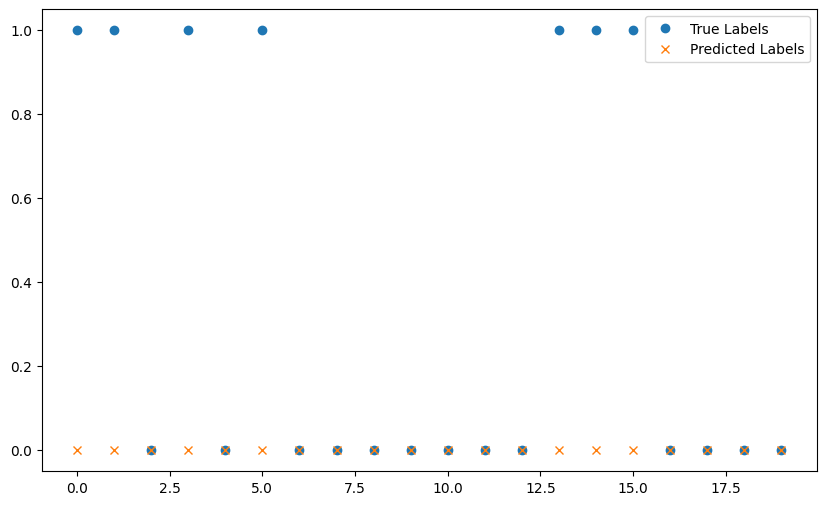

In [64]:
# Разделение данных на вход (X) и метки (y)
X = signals_0_transformed.unsqueeze(-1)  # (batch_size, seq_len, input_size)
y = labels_transformed

# Создание TensorDataset
dataset = TensorDataset(X, y)

# Разделение на обучающую и тестовую выборки
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Создание DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Параметры модели
input_size = 1  # Один признак на каждый временной шаг
hidden_size = 50
output_size = 1  # Один выход для бинарной классификации
num_layers = 2

model_0 = LSTMBinaryClassifier(input_size, hidden_size, output_size, num_layers)

# 3. Определение функции потерь и оптимизатора
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01)

# 4. Обучение модели
num_epochs = 10
for epoch in range(num_epochs):
    model_0.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model_0(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass и оптимизация
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 5. Оценка модели
model_0.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model_0(batch_X)
        predicted = (outputs > 0.5).float()
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(batch_y.tolist(), label='True Labels', marker='o', linestyle='None')
plt.plot(predicted.tolist(), label='Predicted Labels', marker='x', linestyle='None')
plt.legend()
plt.show()

In [89]:
def pipeline_0_model_iteration(N, save_weights_name, _channel=0, num_epochs=10, lr=0.01, momentum=0.9, weight_decay=0.0001):
    metadata_filepath = 'metadata.csv'
    sample_freq = 500

    # Загружаем данные
    signals, labels = load_data(metadata_filepath, sample_freq, N_end=N)

    # Трансформируем данные для обучения из всех отведений (отдельно, потому что используем ансамбль LSTM)
    signals_X_transformed = []
    for i in range(12):
        signals_X_transformed.append(signal_transform_tensor(signals, i))

    labels_transformed = label_transform_tensor(labels)

    # Разделение данных на вход (X) и метки (y)
    X = signals_X_transformed[_channel].unsqueeze(-1)  # (batch_size, seq_len, input_size)
    y = labels_transformed

    # Создание TensorDataset
    dataset = TensorDataset(X, y)

    # Разделение на обучающую и тестовую выборки
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Создание DataLoader
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Параметры модели
    input_size = 1  # Один признак на каждый временной шаг
    hidden_size = 50
    output_size = 1  # Один выход для бинарной классификации
    num_layers = 1

    model_0 = LSTMBinaryClassifier(input_size, hidden_size, output_size, num_layers)

    # Определение функции потерь и оптимизатора
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    # optimizer = torch.optim.Adam(model_0.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer = torch.optim.SGD(model_0.parameters(), lr=0.001, momentum=momentum, weight_decay=weight_decay)

    # Обучение модели
    for epoch in range(num_epochs):
        model_0.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model_0(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass и оптимизация
            loss.backward()
            optimizer.step()
        
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Оценка модели
    model_0.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model_0(batch_X)
            predicted = (outputs > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Визуализация результатов
    plt.figure(figsize=(10, 6))
    plt.plot(batch_y.tolist(), label='True Labels', marker='o', linestyle='None')
    plt.plot(predicted.tolist(), label='Predicted Labels', marker='x', linestyle='None')
    plt.legend()
    plt.show()

    torch.save(model_0.state_dict(), save_weights_name)

    return model_0

Epoch [5/10], Loss: 0.6931
Epoch [10/10], Loss: 0.6904
Test Accuracy: 0.5769


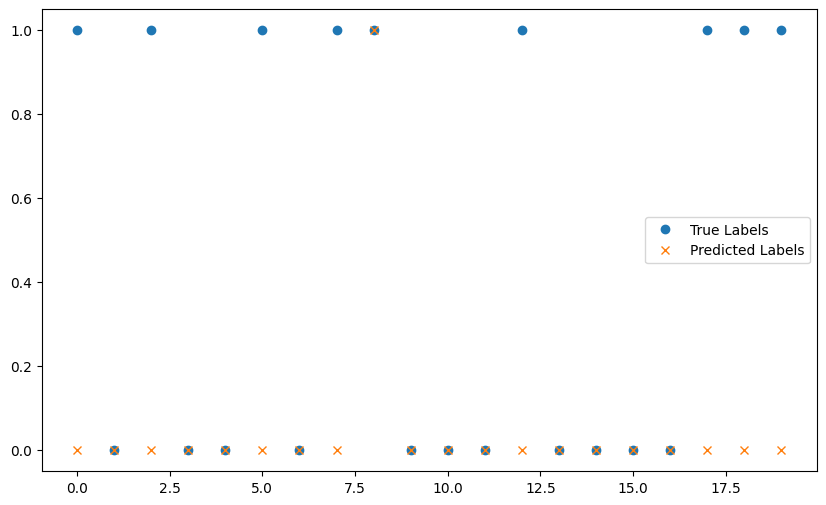

LSTMBinaryClassifier(
  (conv): Conv1d(1, 50, kernel_size=(7,), stride=(1,), padding=(1,))
  (lstm): LSTM(50, 50, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [90]:
save_path = './weights/0/2_SGD_10_0.01_0.9_0.0001.pth'
# save_path = './weights/11/1.pth'

pipeline_0_model_iteration(256, save_path, _channel=0)